# Joint distributions exercise

You are given a three-dimensional dataset with variables:

- 'Wsp' is the 10-minute average wind speed;
- 'SigmaU' is the standard deviation of the 10-minute average wind speed;
- 'Rho' is the air density

The wind speed and turbulence are conditionally dependent on each other, while the air density can be considered independent from the other two variables. 

Your task is to:

1) Load the dataset 'Multivariate_dist_exercise_data.csv' into pandas
2) Try to plot the variables and illustrate their dependencies
3) Fit a marginal Weibull distribution to the wind speed 
4) Fit a conditional LogNormal distribution to the turbulence, considering a linear or quadratic dependence of the mean turbulence to the wind speed;
5) Fit a Normal distribution to the air density: does it have to be conditional or not?
6) Try to generate a random sample of the three varaibles and compare to the original data set

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy
import matplotlib.pyplot as plt
import sklearn
import sklearn.neural_network
from scipy.special import erf, erfinv
import seaborn as sns

In [2]:
WindData = pd.read_csv('../Datasets/Multivariate_dist_exercise_data.csv')

In [3]:
WindData

,Wsp,SigmaU,Rho
0,9.9196,0.179545,1.284383
1,9.5073,0.137856,1.211200
2,9.5274,0.200075,1.212646
3,9.9498,0.251730,1.258337
4,10.2376,0.154588,1.191076
...,...,...,...
429724,15.6264,1.207921,1.195205
429725,13.7150,0.789984,1.232585
429726,13.4969,1.075703,1.241341
429727,13.4135,1.386956,1.238772


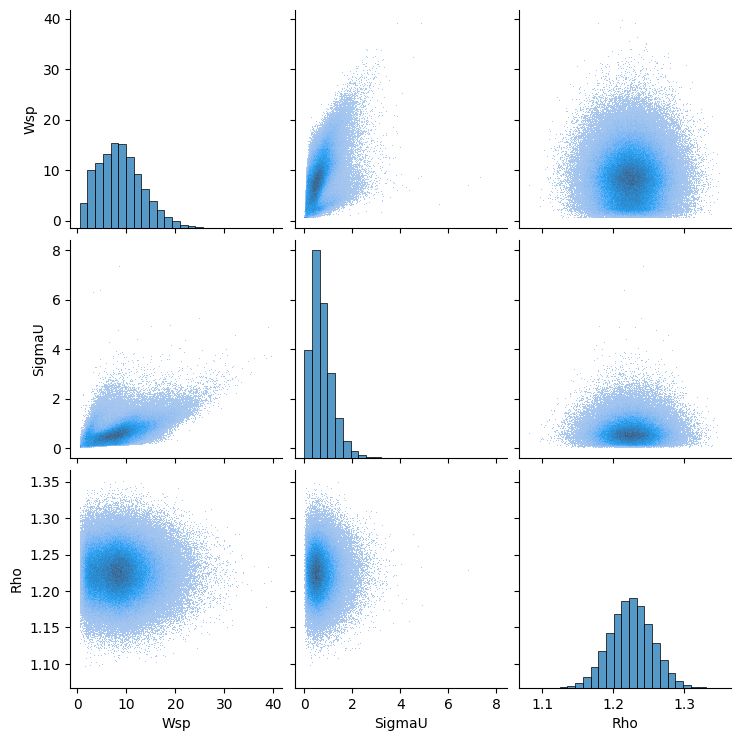

In [4]:
sns.pairplot(WindData, kind='hist', diag_kws={'bins': 25})

In [5]:
# Helper function - Normal distribution
def NormalDist(task, x, mu=0, sigma=1):
    """Normal distribution function

    Parameters
    ----------
    task : int
        0: PDF, 1: Cumulative, 2: Inverse
    x : np.array
        Data
    mu : float, optional
        Mean, by default 0
    sigma : float, optional
        Standard deviation, by default 1
    Returns
    -------
    np.array
        Normal distribution y values for the given task
    """
    
    if task == 0:  # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi))) * \
            np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
            
    elif task == 1:  # Cumulative
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
        
    elif task == 2:  # Inverse
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)
    
    return y

# Helper function - lognormal distribution
def LogNormDist(task, x, mu, sigma):
    """Lognormal distribution function

    Parameters
    ----------
    task : int
        0: PDF, 1: Cumulative, 2: Inverse
    x : np.array
        Data
    mu : float
        Mean
    sigma : float
        Standard deviation

    Returns
    -------
    np.array
        Lognormal distribution y values for the given task
    """
    tol = 1e-16
    mu = np.asarray(mu)
    mu[mu < tol] = tol
    Eps = np.sqrt(np.log(1.0+(sigma/mu)**2))
    Ksi = np.log(mu)-0.5*Eps**2
    
    if task == 0:  # PDF
        x[x <= 0] = 1e-8
        u = (np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
        
    elif task == 1:  # Cummulative
        x[x <= 0] = 1e-8
        u = (np.log(x)-Ksi)/Eps
        y = NormalDist(1, u)
        
    elif task == 2:  # Inverse
        y = np.exp(Ksi+Eps*NormalDist(2, x))

    return y

In [6]:
# WIND SPEED DISTRIBUTION FIT
Wsp0 = np.asarray(WindData['Wsp']) # Wind speed data
WeibLikelihoodFunc = lambda x: -np.sum(np.log(stats.weibull_min.pdf(Wsp0, x[0], 0, x[1])))
Weib0 = scipy.optimize.minimize(WeibLikelihoodFunc, [1, 1], method='Nelder-Mead')
WeibullA = Weib0.x[0]
Weibullk = Weib0.x[1]

In [28]:
# CONDITION DISTRIBUTION OF TURBULENCE - BASED ON DATA BINNING
WspBinEdges = np.arange(3.5, 33.5, 1)
WspBinCenters = WspBinEdges[:-1] + 0.5

MuSigmaBinned = np.zeros(len(WspBinCenters))
SigmaSigmaBinned = np.zeros(len(WspBinCenters))

nData = len(WindData['Wsp'])

scale_arr = np.zeros_like(WspBinCenters)
shape_arr = np.zeros_like(WspBinCenters)

# Per wind speed
for iWsp in range(len(WspBinCenters)):
    WspBinSelection = (WindData['Wsp'] > WspBinEdges[iWsp]) & (
        WindData['Wsp'] <= WspBinEdges[iWsp + 1])
    MuSigmaBinned[iWsp] = np.mean(WindData.loc[WspBinSelection, 'SigmaU'])
    SigmaSigmaBinned[iWsp] = np.std(WindData.loc[WspBinSelection, 'SigmaU'])
    
    Sigma0 = np.asarray(WindData.loc[WspBinSelection, 'SigmaU']) # Wind speed data
    # Using lognormal distribution LogNormDist
    # Sigma0 = Sigma0[~np.isnan(Sigma0)]
    LogNormLikelihoodFunc = lambda x: -np.sum(np.log(stats.lognorm.pdf(Sigma0, loc=0, scale=x[0], s=x[1])))
    LogNorm0 = scipy.optimize.minimize(LogNormLikelihoodFunc, [2, 2], method='Nelder-Mead')
    LogNormMu = LogNorm0.x[0]
    LogNormSigma = LogNorm0.x[1]
    scale_arr[iWsp] = LogNormMu
    shape_arr[iWsp] = LogNormSigma
    


Mudatax = WspBinCenters[~np.isnan(MuSigmaBinned)]
Mudatay = MuSigmaBinned[~np.isnan(MuSigmaBinned)]

# Use polyfit (for example np.polyfit). Which order works well - 0, 1, or 2?
pMu0 = np.polyfit(Mudatax, Mudatay, 0)
pMu1 = np.polyfit(Mudatax, Mudatay, 1)
pMu2 = np.polyfit(Mudatax, Mudatay, 2)

SigmaSigmaRef = np.mean(SigmaSigmaBinned) # 


def MuSigmaFunc(u, pMu):
    return np.polyval(pMu, u)


def SigmaSigmaFunc(u):
    return

C:\conda_temp\ipykernel_18720\2356257472.py:23: RuntimeWarning: divide by zero encountered in log
  LogNormLikelihoodFunc = lambda x: -np.sum(np.log(stats.lognorm.pdf(Sigma0, loc=0, scale=x[0], s=x[1])))


In [29]:
shape_arr

array([0.75009009, 0.70749684, 0.65399547, 0.62191572, 0.5885034 ,
       0.5572774 , 0.52032746, 0.49583637, 0.47480699, 0.45474389,
       0.41631452, 0.39663315, 0.3766151 , 0.35199333, 0.30590527,
       0.26938743, 0.23667192, 0.22330784, 0.22058134, 0.20030796,
       0.18702607, 0.20132093, 0.19680208, 0.17470387, 0.15536057,
       0.19875218, 0.16834357, 0.12058321, 0.15284929])

In [30]:
scale_arr

array([0.45096509, 0.46042179, 0.47522133, 0.50599032, 0.53790791,
       0.59207727, 0.65215812, 0.71525697, 0.76875155, 0.80017111,
       0.85782352, 0.92643222, 0.99561503, 1.0805339 , 1.18985373,
       1.29777886, 1.40632266, 1.52801524, 1.63269721, 1.72000879,
       1.84523118, 1.98532521, 2.1773884 , 2.30529218, 2.45500071,
       2.49010295, 2.66049496, 2.66488833, 2.76572874])

In [112]:
Mudatax

array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
       17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29.,
       30., 31., 32.])

In [113]:
Mudatay

array([0.58374547, 0.58655747, 0.58688037, 0.61135712, 0.63466387,
       0.6842432 , 0.73860229, 0.80061472, 0.85247219, 0.8807507 ,
       0.93125555, 0.99860605, 1.0657026 , 1.14662016, 1.24541759,
       1.34633102, 1.4469836 , 1.56721226, 1.67421672, 1.75538504,
       1.87827595, 2.02774334, 2.22130409, 2.3408207 , 2.48486349,
       2.5397607 , 2.69872848, 2.68494456, 2.80071009])

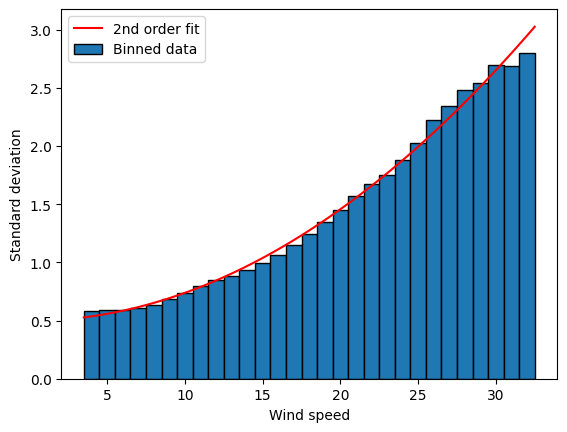

In [114]:
x_plot = np.linspace(WspBinEdges[0], WspBinEdges[-1], 100)
y_plot0 = MuSigmaFunc(x_plot, pMu0)
y_plot1 = MuSigmaFunc(x_plot, pMu1)
y_plot2 = MuSigmaFunc(x_plot, pMu2)

plt.bar(Mudatax, Mudatay, width=1, edgecolor='black', label='Binned data')
# plt.plot(x_plot, y_plot0, label='0th order fit', zorder=10)
# plt.plot(x_plot, y_plot1, label='1st order fit', zorder=10)
plt.plot(x_plot, y_plot2, label='2nd order fit', zorder=10, color='red')

plt.xlabel('Wind speed')
plt.ylabel('Standard deviation')
plt.legend()
plt.show()

In [31]:
N = 10000
# Random wind speeds based on the weibull distribution
Urand = stats.weibull_min.rvs(WeibullA, 0, Weibullk, size=N)

# SigmaUrand = MuSigmaFunc(Urand, pMu2)  # Random wind speed std based on data binning

# Random wind speed std based on lognormal distribution

# SigmaUrand = stats.lognorm.rvs(loc=0, scale=LogNormMu, s=LogNormSigma, size=N)

# SigmaUrand = np.zeros(N)
# for i in range(N):
#     idx = np.abs(Mudatax - Urand[i]).argmin()
#     SigmaUrand[i] = stats.lognorm.rvs(loc=0, scale=scale_arr[idx], s=shape_arr[idx])

SigmaUrand = np.zeros(Urand.shape)
for i in range(len(Urand)):
    idx = np.abs(Mudatax - Urand[i]).argmin()
    SigmaUrand[i] = stats.lognorm.rvs(loc=0, scale=scale_arr[idx], s=shape_arr[idx])


<Axes: ylabel='Count'>

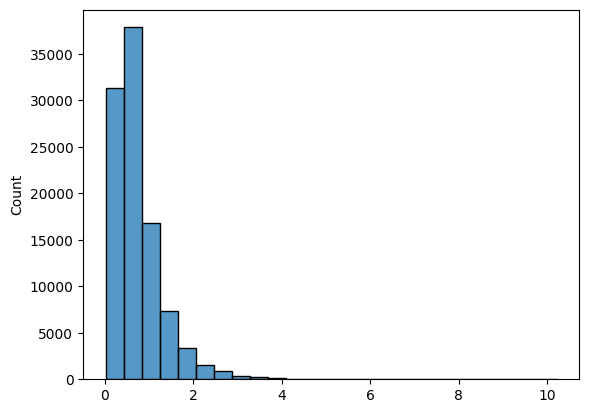

In [118]:
sns.histplot(SigmaUrand, bins=25)

<Axes: ylabel='Count'>

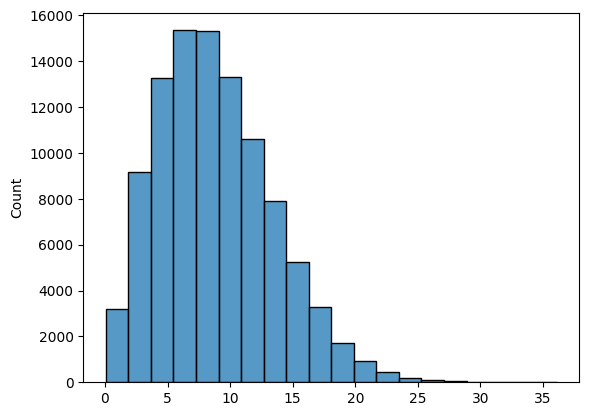

In [119]:
sns.histplot(Urand, bins=20)

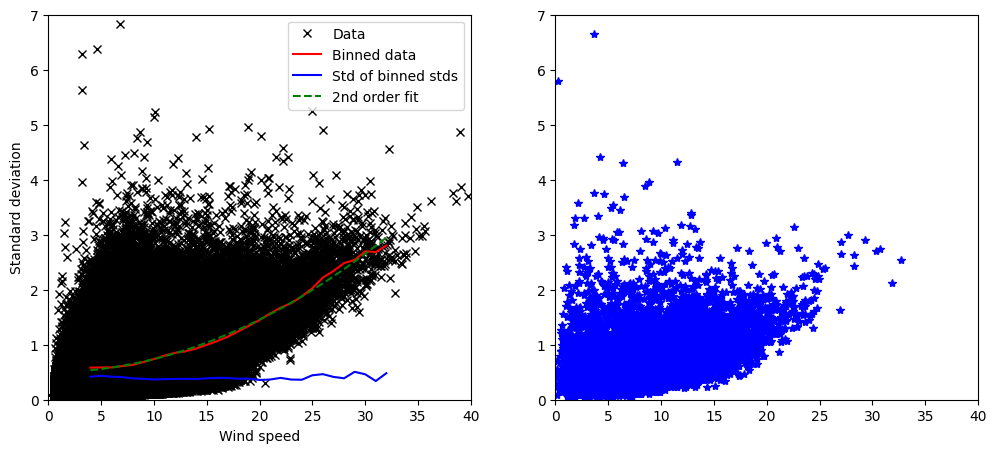

In [32]:
# PLOT TURBULENCE INCLUDING DISTRIBUTION PARAMETERS

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(WindData['Wsp'], WindData['SigmaU'], 'xk', label='Data')
ax[0].plot(WspBinCenters, MuSigmaBinned, '-r', label='Binned data')
ax[0].plot(WspBinCenters, SigmaSigmaBinned, '-b', label='Std of binned stds')
ax[0].plot(WspBinCenters, MuSigmaFunc(WspBinCenters, pMu2), '--g', label='2nd order fit')
ax[0].set_xlim([0, 40])
ax[0].set_ylim([0, 7])
ax[0].set_xlabel('Wind speed')
ax[0].set_ylabel('Standard deviation')
ax[0].legend()
ax[1].plot(Urand, SigmaUrand, '*b')
ax[1].set_xlim([0, 40])
ax[1].set_ylim([0, 7])

plt.show()